<a href="https://colab.research.google.com/github/SurekhaBerlin/Machine-Learning/blob/main/CaliforniaHousingPricePredictionML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score,accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
import warnings
warnings.filterwarnings('ignore')

When load_housing_data() is called, it looks for the datasets/housing.tgz file. If it does not find it, it creates the datasets directory inside the current directory (which is /content by default, in Colab), downloads the housing.tgz file from the ageron/data GitHub repository, and extracts its content into the datasets directory; this creates the datasets/housing directory with the housing.csv file inside it.

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

The info() method is useful to get a quick description of the data, in particular the total number of rows, each attribute’s type, and the number of non-null values:

Take a Quick Look at the Data Structure

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**207 districts are missing this feature. **

There are 10 attributes (they are not all shown in the screenshot): longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, median_house_value, and ocean_proximity.

In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


There are 20,640 instances in the dataset, which means that it is fairly small by machine learning standards, but it’s perfect to get started. You notice that the total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature.

All attributes are numerical, except for ocean_proximity,The values in the ocean_proximity column were repetitive, which means that it is probably a categorical attribute.

In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored (so, for example, the count of total_bedrooms is 20,433, not 20,640). The std row shows the standard deviation, which measures how dispersed the values are.⁠5 The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall.

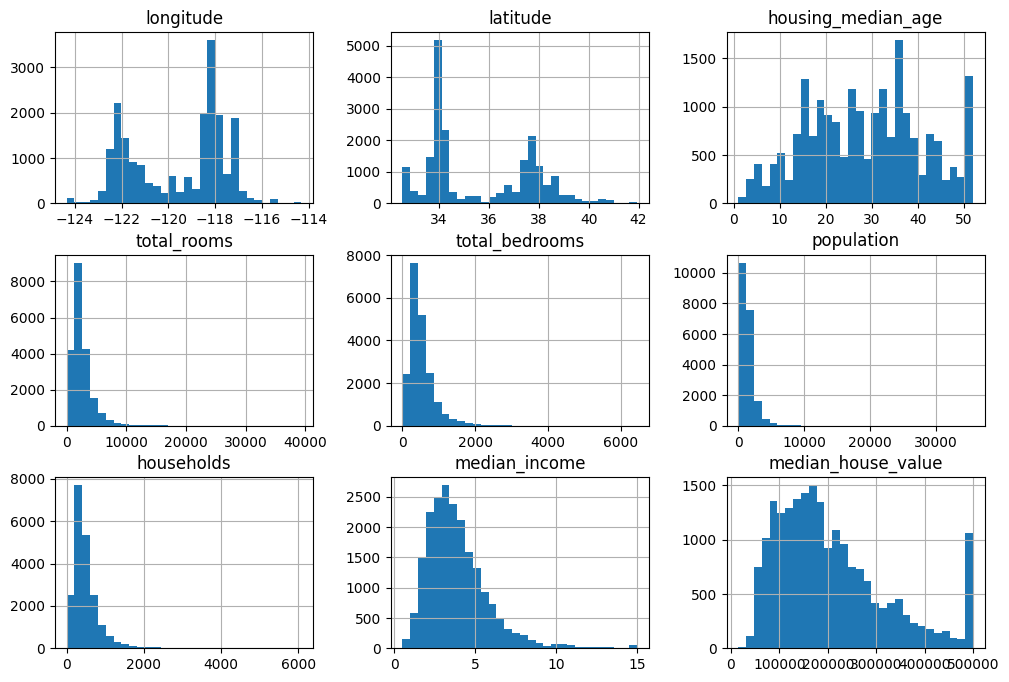

In [8]:
housing.hist(bins=30, figsize=(12, 8))
plt.show()

Many histograms are skewed right: they extend much farther to the right of the median than to the left. This may make it a bit harder for some machine learning algorithms to detect patterns. Later, you’ll try transforming these attributes to have more symmetrical and bell-shaped distributions.


In [9]:
housing.dropna(inplace = True)

In [10]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [11]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Visualize the Data to Gain Insights

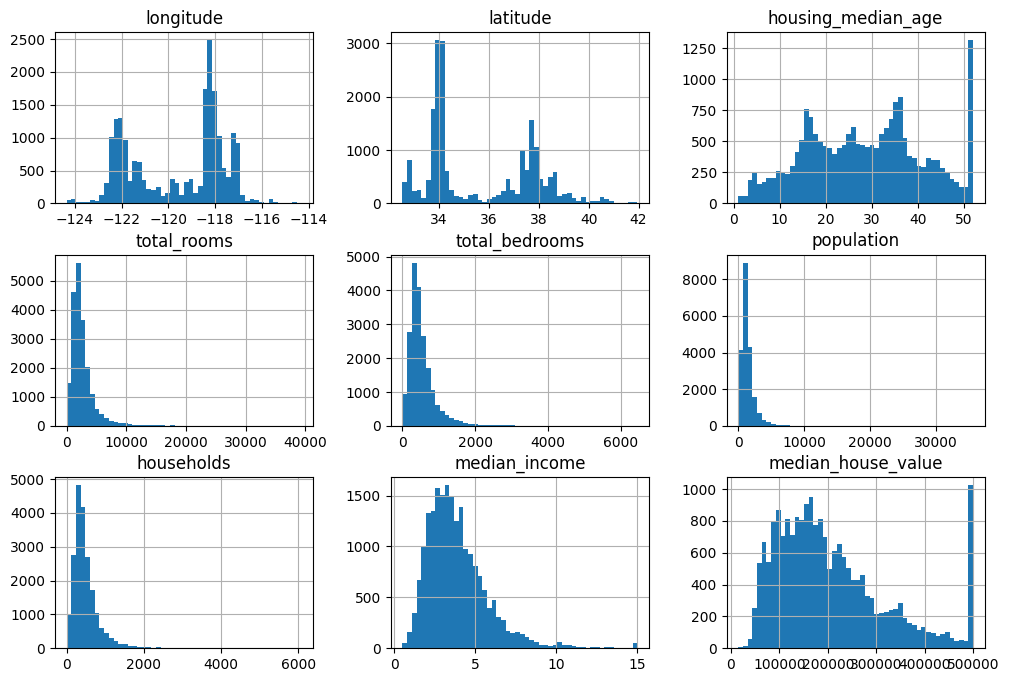

In [12]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [41]:
corr_matrix = housing.corr()

In [42]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688355
income_cat            0.643941
<1H OCEAN             0.257614
NEAR BAY              0.160526
total_rooms           0.158506
NEAR OCEAN            0.140378
households_rooms      0.114094
housing_median_age    0.106432
households            0.072765
total_bedrooms        0.053311
ISLAND                0.023525
population           -0.021904
longitude            -0.045398
latitude             -0.144638
bedroom_ratio        -0.198690
INLAND               -0.484787
Name: median_house_value, dtype: float64

<Axes: >

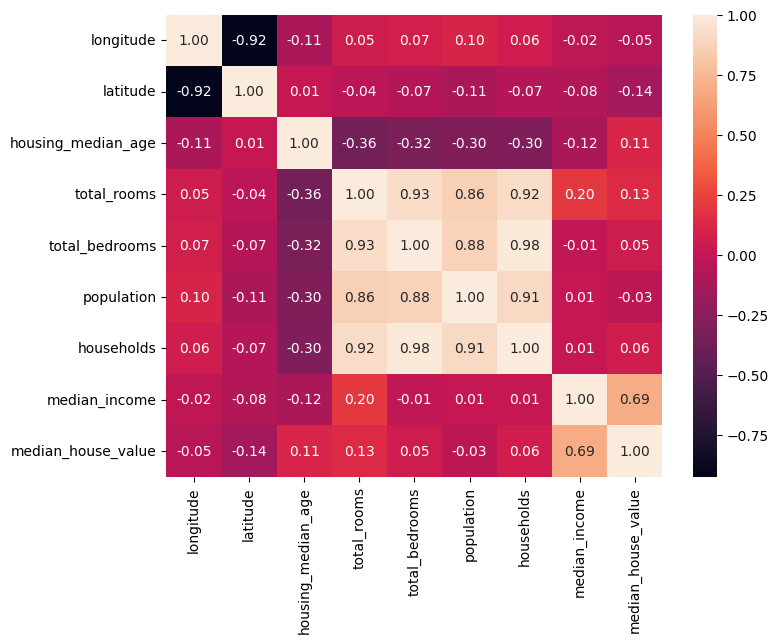

In [13]:
correlation_matrix = housing.corr(numeric_only=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix,annot = True, cmap="rocket", fmt=".2f")

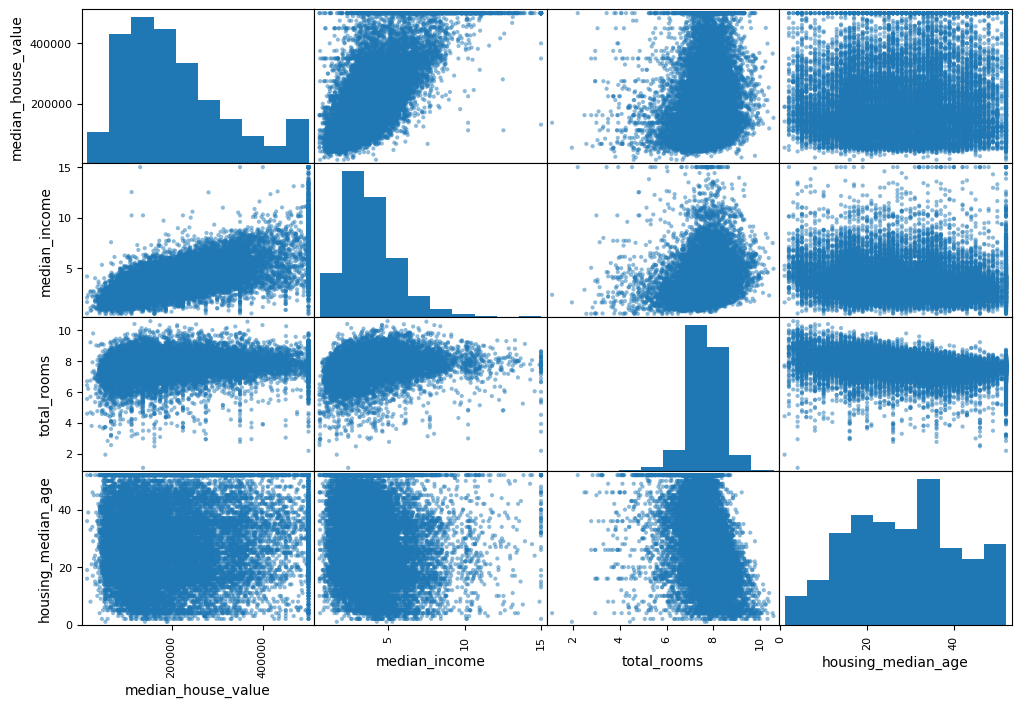

In [43]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [14]:
housing['total_rooms'] = np.log(housing['total_rooms']+ 1)
housing['total_bedrooms'] = np.log(housing['total_bedrooms']+ 1)
housing['population'] = np.log(housing['population']+ 1)
housing['households'] = np.log(housing['households']+ 1)

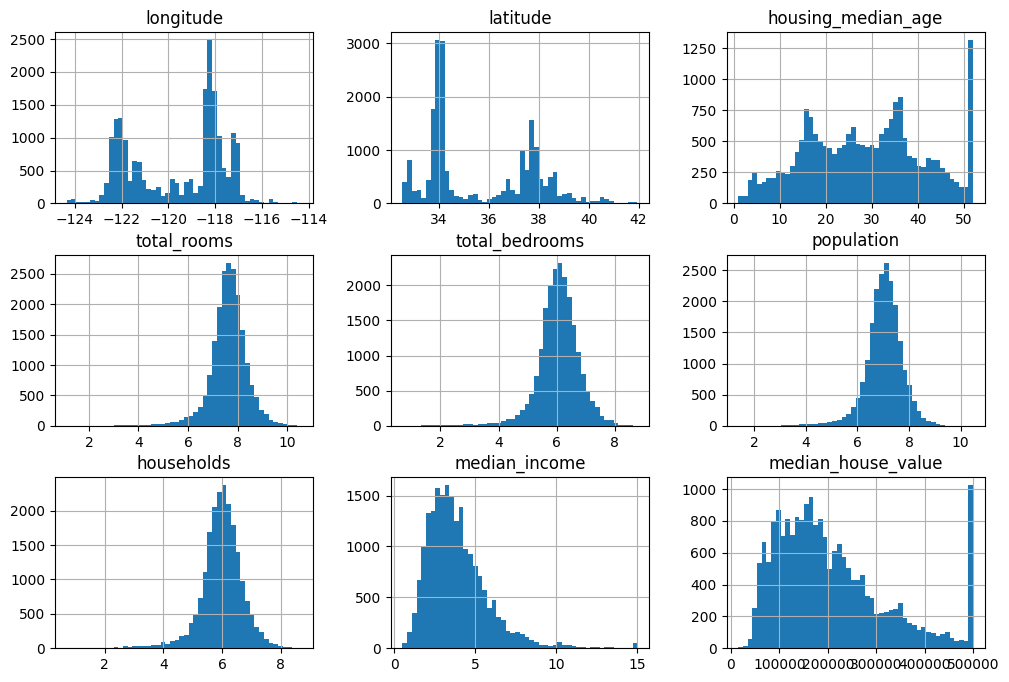

In [15]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In [16]:
housing.ocean_proximity.value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [17]:
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,6.781058,4.867534,5.777652,4.844187,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,8.867850,7.009409,7.784057,7.037906,8.3014,358500.0,NEAR BAY


In [18]:
housing = housing.join(pd.get_dummies(housing.ocean_proximity)).drop(['ocean_proximity'],axis = 1)

In [19]:
housing.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,6.781058,4.867534,5.777652,4.844187,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,8.867850,7.009409,7.784057,7.037906,8.3014,358500.0,False,False,False,True,False


<Axes: >

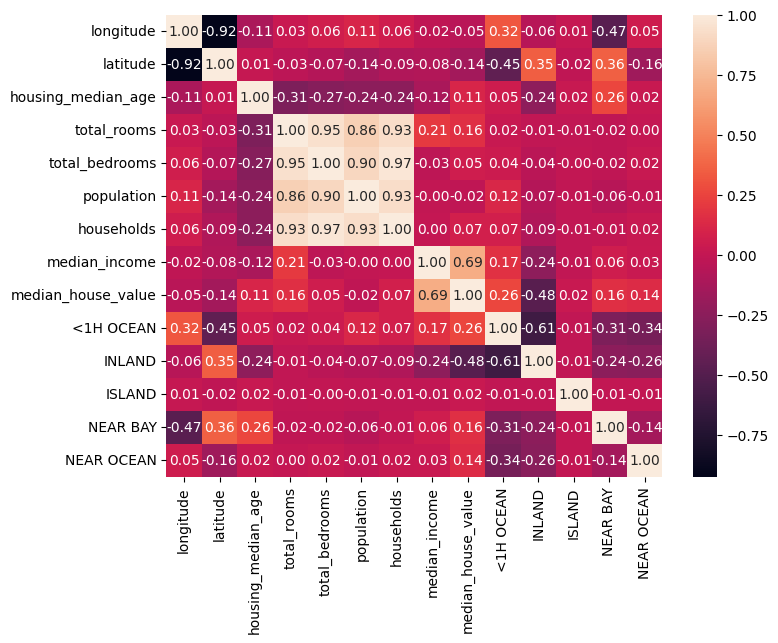

In [20]:
correlation_matrix = housing.corr(numeric_only=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix,annot = True, cmap="rocket", fmt=".2f")

<Axes: xlabel='latitude', ylabel='longitude'>

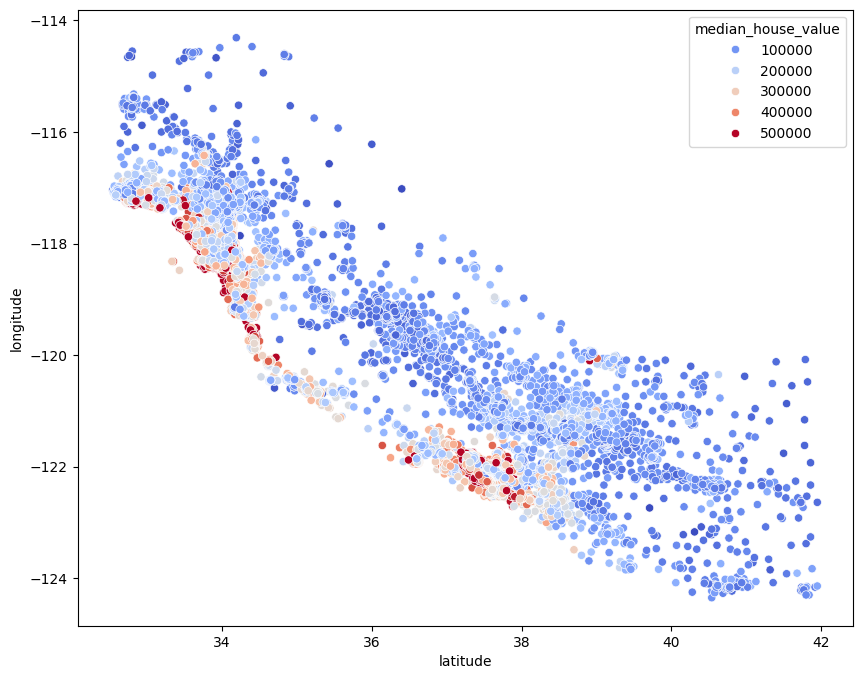

In [21]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = "latitude",y = "longitude", data= housing,hue = "median_house_value",palette = 'coolwarm')

In [22]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

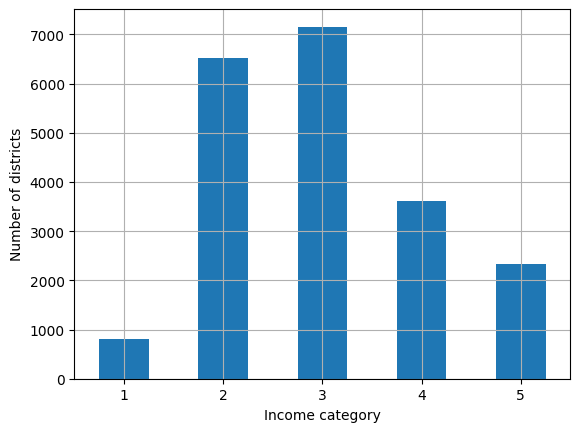

In [23]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

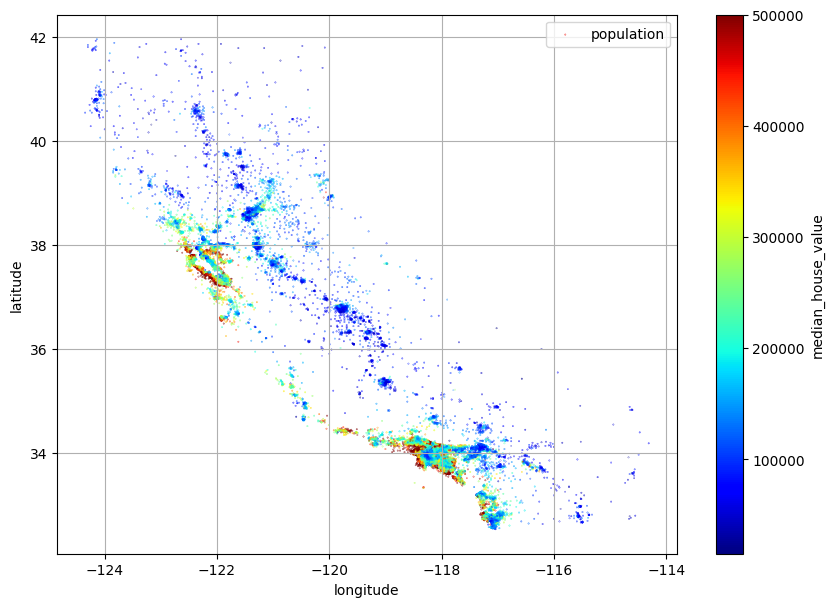

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

## Prepare the Data for Machine Learning Algorithms

1. Get rid of the corresponding districts.
2. Get rid of the whole attribute.
3. Set the missing values to some value (zero, the mean, the median, etc.). This is called imputation.




*   You can accomplish these easily using the Pandas DataFrame’s dropna(), drop(), and fillna() methods:

In [25]:
housing['bedroom_ratio'] = housing['total_bedrooms']/housing['total_rooms']

In [26]:
housing['households_rooms'] = housing['total_rooms']/housing['households']

<Axes: >

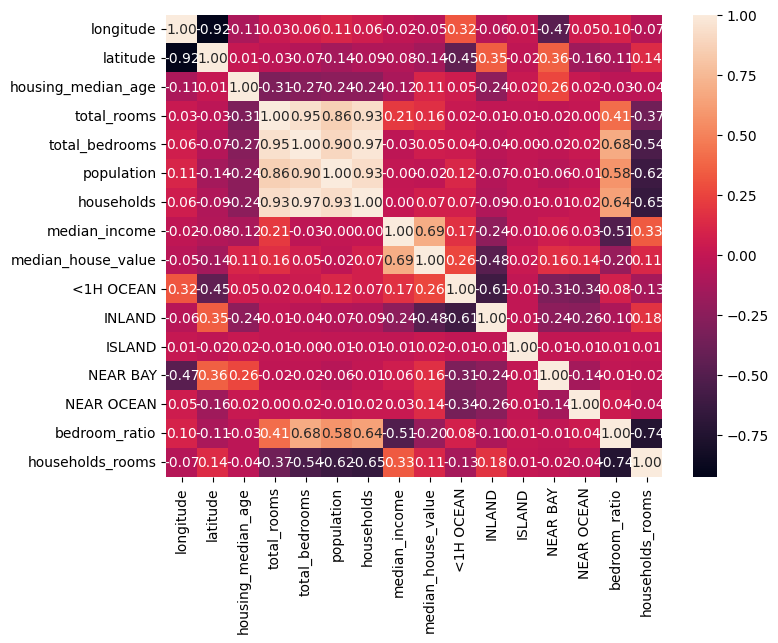

In [27]:
correlation_matrix = housing.corr(numeric_only=True)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix,annot = True, cmap="rocket", fmt=".2f")

In [28]:
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,income_cat,bedroom_ratio,households_rooms
0,-122.23,37.88,41.0,6.781058,4.867534,5.777652,4.844187,8.3252,452600.0,False,False,False,True,False,5,0.717813,1.399834
1,-122.22,37.86,21.0,8.867850,7.009409,7.784057,7.037906,8.3014,358500.0,False,False,False,True,False,5,0.790429,1.260013
2,-122.24,37.85,52.0,7.291656,5.252273,6.208590,5.181784,7.2574,352100.0,False,False,False,True,False,5,0.720313,1.407171


In [29]:
X = housing.drop(['median_house_value'],axis = 1)
y = housing['median_house_value']

In [30]:
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size = 0.2)

In [31]:
X_train.shape

(16346, 16)

In [32]:
lr = LinearRegression()

In [33]:
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred_lr = lr.predict(X_test)

In [35]:
lr.score(X_test,y_test)

0.6611959859933956

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
rfr = RandomForestRegressor()

In [38]:
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [39]:
rfr.score(X_test,y_test)

0.8040869678857199